# Main ERP Pipeline

This notebook contains processing steps for BCI III P300 dataset.
The goal is to classify ERP forms for target and common stimuli using peak features

In [858]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [859]:
import sys
sys.path.append("../src")

In [860]:
from load import load_bci_iii_data as load_data

In [861]:
from preprocess import process_signal, restore_raw, get_events

In [862]:
import pandas as pd

In [863]:
import matplotlib.pyplot as plt

# Load and preprocess data

You can find the description of each method in the related src/*.py file

In [864]:
good_subject = "Subject_B_Train"

In [948]:
sessions_df, characters = load_data(good_subject)

In [949]:
i = 1
session_df = sessions_df[sessions_df["InputIndex"] == i]
character = characters[0][i]

In [950]:
from preprocess import *

In [951]:
raw = restore_raw(session_df)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.


../src/preprocess.py:20: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


In [952]:
events = get_events(raw)

180 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12]


In [953]:
filter_signal(raw)

Setting up band-stop filter from 49 - 51 Hz
Filter length of 1585 samples (6.604 sec) selected
Setting up band-pass filter from 0.5 - 30 Hz
l_trans_bandwidth chosen to be 0.5 Hz
h_trans_bandwidth chosen to be 7.5 Hz
Filter length of 1585 samples (6.604 sec) selected


In [954]:
raw = scale_signal(raw, events, session_df)

Creating RawArray with float64 data, n_channels=65, n_times=7794
    Range : 0 ... 7793 =      0.000 ...    32.471 secs
Ready.
The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.


../src/preprocess.py:20: RuntimeWarning: The unit for channel(s) Af3, Af4, Af7, Af8, Afz, C1, C2, C3, C4, C5, C6, Cp1, Cp2, Cp3, Cp4, Cp5, Cp6, Cpz, Cz, F1, F2, F3, F4, F5, F6, F7, F8, Fc1, Fc2, Fc3, Fc4, Fc5, Fc6, Fcz, Fp1, Fp2, Fpz, Ft7, Ft8, Fz, Iz, O1, O2, Oz, P1, P2, P3, P4, P5, P6, P7, P8, Po3, Po4, Po7, Po8, Poz, Pz, T10, T7, T8, T9, Tp7, Tp8 has changed from NA to V.
  raw.set_channel_types(channel_types)


In [955]:
cleaned_events = reject_bad_events(raw, events)

In [956]:
epochs = get_epochs(raw, events)

110 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 110 events and 193 original time points ...
1 bad epochs dropped


# Experimental section

Perform an averaging of the signal for each character to find P300 manually

In [957]:
chars = [chr(ord('A') + i) for i in range(0, 26)] + [str(i) for i in range(1, 10)] + ["_"]

char_events = {
    chars[i]: [str(i % 6 + 1), str(i // 6 + 7)]
    for i in range(0, 36)
}

G
time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning


<ipython-input-958-65788a1a5e13>:5: DeprecationWarning: time_unit defaults to "ms" in 0.16 but will change to "s" in 0.17, set it explicitly to avoid this warning
  epochs[events].average().plot()


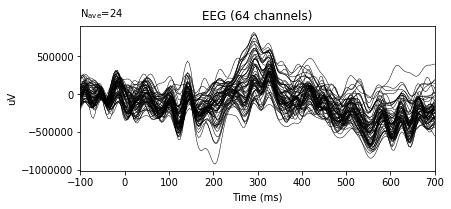

In [958]:
for char in chars:
    events = char_events[char]
    if char == character:
        print(char)
        epochs[events].average().plot()
    plt.show()

Get FFT decomposition of the signal for the certain character

In [877]:
events = char_events['G']

In [853]:
signal = epochs[events].average().data

In [854]:
signal_fft = np.abs(np.fft.fft(signal, axis=1))

In [855]:
signal_fft[:, :signal_fft.shape[-1] // 2].shape

(64, 96)

In [856]:
import seaborn as sns

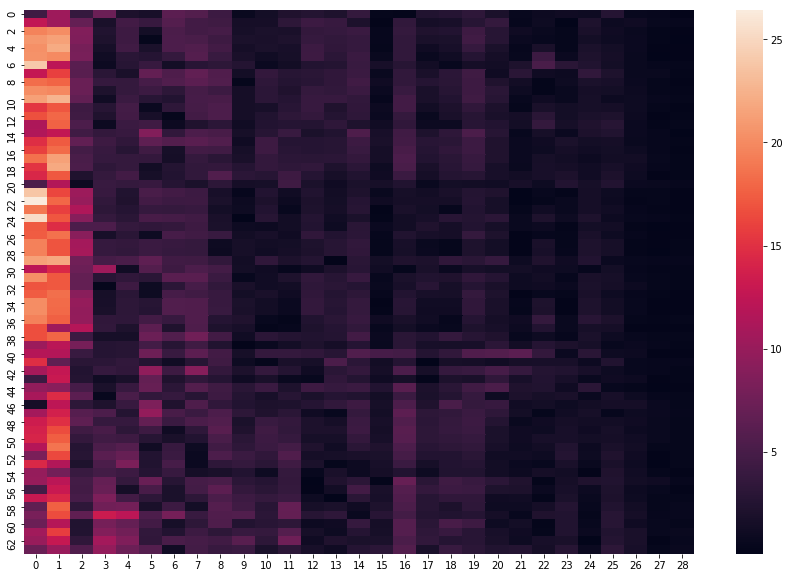

In [857]:
sns.heatmap(signal_fft[:, 1:30])

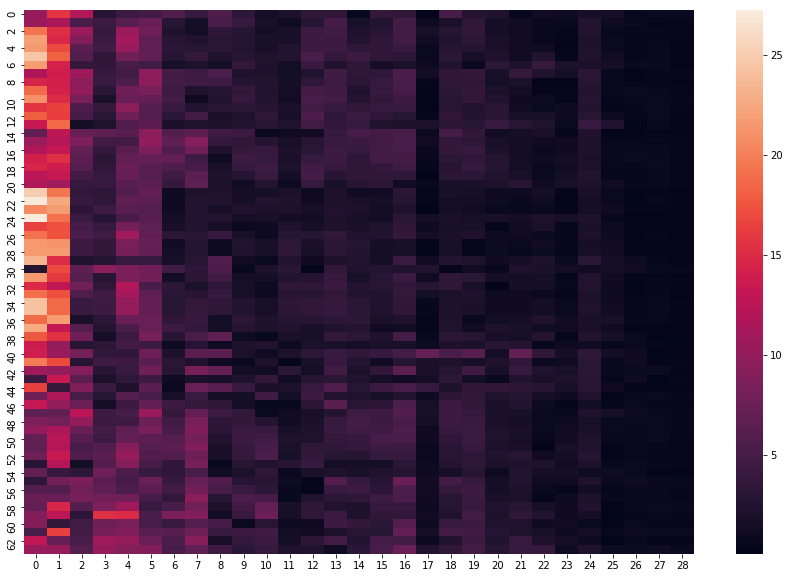

In [851]:
sns.heatmap(signal_fft[:, 1:30])

In [795]:
signal.shape

(64, 193)

In [786]:
events = char_events[character] 
extract_features('s1', epochs[events], sliding_window_size=12)

Averaging by 24 attemps


[[396.875, 0.1901147757265359, 0.20684920720003508, 12.5, 12.5, 0, 's1'],
 [418.75, 0.2331221548863106, 0.5227947693939884, 12.5, 34.375, 1, 's1'],
 [396.875, 0.31329240919167134, 0.18193203040750408, 34.375, 12.5, 2, 's1'],
 [396.875, 0.6740905846789128, 0.1263286107652129, 96.875, 12.5, 3, 's1'],
 [396.875, 0.7611099966475248, 0.18677775718439238, 96.875, 12.5, 4, 's1'],
 [393.75, 0.4658931455482949, 0.20784941044862598, 43.75, 15.625, 5, 's1'],
 [390.625, 0.253728230178136, 0.22982031853692125, 15.625, 15.625, 6, 's1'],
 [418.75, 0.2769373707628518, 0.3576898078776644, 12.5, 15.625, 7, 's1'],
 [418.75, 0.18431649394526717, 0.4413901781792146, 12.5, 37.5, 8, 's1'],
 [418.75, 0.13771216693948843, 0.44865661229602105, 12.5, 37.5, 9, 's1'],
 [418.75, 0.13367607003713164, 0.5059916157985636, 12.5, 37.5, 10, 's1'],
 [418.75, 0.15488115909125988, 0.5446359234981913, 12.5, 34.375, 11, 's1'],
 [393.75, 0.22985220712882184, 0.2072605813864882, 15.625, 12.5, 12, 's1'],
 [393.75, 0.203985239513

In [787]:
char = 'M'
events = char_events[char] 
extract_features('s1', epochs[events], sliding_window_size=12)

Averaging by 22 attemps


[[200.0, 0.35952809653946344, 0.44871691317814744, 18.75, 31.25, 0, 's1'],
 [415.625, 0.22152170492951126, 0.47756336888634965, 53.125, 40.625, 1, 's1'],
 [421.875, 0.14066251835076768, 0.6123264474540089, 12.5, 37.5, 2, 's1'],
 [421.875, 0.13187804081147853, 0.6302738674843023, 15.625, 37.5, 3, 's1'],
 [421.875, 0.15876770039166993, 0.6522736924461163, 15.625, 37.5, 4, 's1'],
 [421.875, 0.21397656127168863, 0.5993915541504028, 12.5, 37.5, 5, 's1'],
 [393.75, 0.48771171361031007, 0.32429886956389137, 37.5, 12.5, 6, 's1'],
 [200.0, 0.49234635889075196, 0.4880541757133985, 15.625, 25.0, 7, 's1'],
 [396.875, 0.2261863708704608, 0.11008441040843936, 21.875, 12.5, 8, 's1'],
 [421.875, 0.11668055225976748, 0.49891857364001, 12.5, 34.375, 9, 's1'],
 [421.875, 0.16505570327409627, 0.6109870664040863, 15.625, 37.5, 10, 's1'],
 [421.875, 0.19843257235412934, 0.5659346941331733, 15.625, 37.5, 11, 's1'],
 [421.875, 0.27254816233157303, 0.5383395336300708, 12.5, 37.5, 12, 's1'],
 [393.75, 0.4833907

In [334]:
from peaks import extract_features